In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Imports
import pandas as pd
from src.debate_manager import DebateManager
from src.debate_processor import process_debate
from src.visualization import graph_scene_graph, graph_all_scene_graphs
from src.utils import save_results, calculate_rmse, generate

yay


In [2]:
# Loading DebateArt

# Load the CSV file
file_path = 'data/panel_bench/DebateArt/gold/dimension.csv'
df = pd.read_csv(file_path)

# Extract the dart_id column and format it
dart_ids = list(dict.fromkeys(df['dart_id'].apply(lambda x: f"{x:04d}").tolist()))

# Loading Manager
manager = DebateManager("config/data_config.yaml", debate_format="debateart")

# Print the formatted dart_ids
print(dart_ids)
print(len(dart_ids))

Loaded Config: {'datasets': {'bp_competition': {'data_dir': 'data/panel_bench/BP-Competition', 'formats': {'motion': 'motion/bp_{id}.yml', 'speech': 'speech/bp_{id}.yml'}}, 'debateart': {'data_dir': 'data/panel_bench/DebateArt', 'formats': {'motion': 'motion/debateart_{id}.yml', 'speech': 'speech/debateart_{id}.yml'}}}}
['0017', '0020', '0130', '0204', '0244', '0290', '0309', '0386', '0466', '0495', '0537', '0566', '0569', '0570', '0578', '0600', '0601', '0616', '0654', '0678', '0679', '0684', '0716', '0731', '0734', '0737', '0750', '0752', '0756', '0769', '0777', '0778', '0796', '0802', '0840', '0866', '0892', '0905', '0931', '0943', '0951', '0956', '0959', '0962', '0987', '0994', '1033', '1043', '1079', '1080', '3638', '3645', '3687', '3696', '3817', '3842', '3867', '3919', '3935', '3943', '3965', '3986', '4005', '4024', '4038', '4066', '4085', '4123', '4286', '4287', '4367', '4374', '4389', '4395', '4398', '4423', '4509', '4562', '4567', '4573', '4617', '4620', '4638', '4640', '4642

In [3]:
# Testing First N Debates
N = 1
winners = []
structs = []

for dart_id in dart_ids[:N]:
    debate = manager.load_debate(dart_id)
    winner, struct = process_debate(debate)
    winners.append(winner)
    structs.append(struct)

print(winners)

['con']


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>

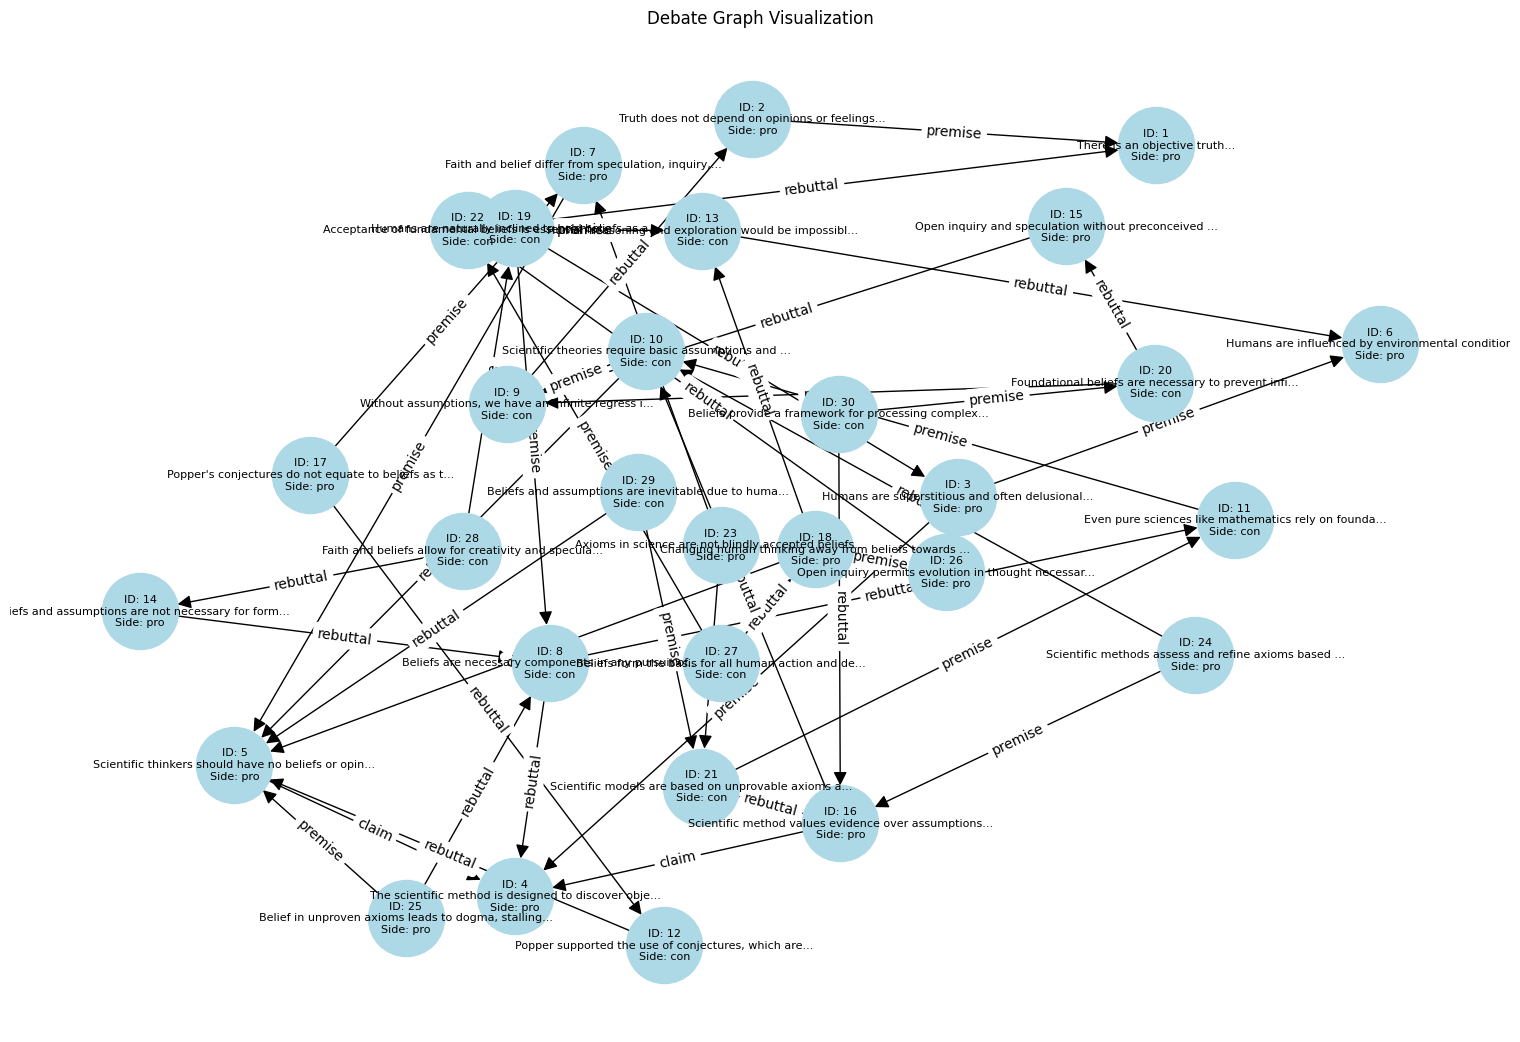

In [4]:
# Graphing results

# View final graph for first debate
graph_scene_graph(structs[0]['graph_history'][-1])

Scene Graph 1:
Scene Graph 2:
Scene Graph 3:
Scene Graph 4:
Scene Graph 5:
Scene Graph 6:


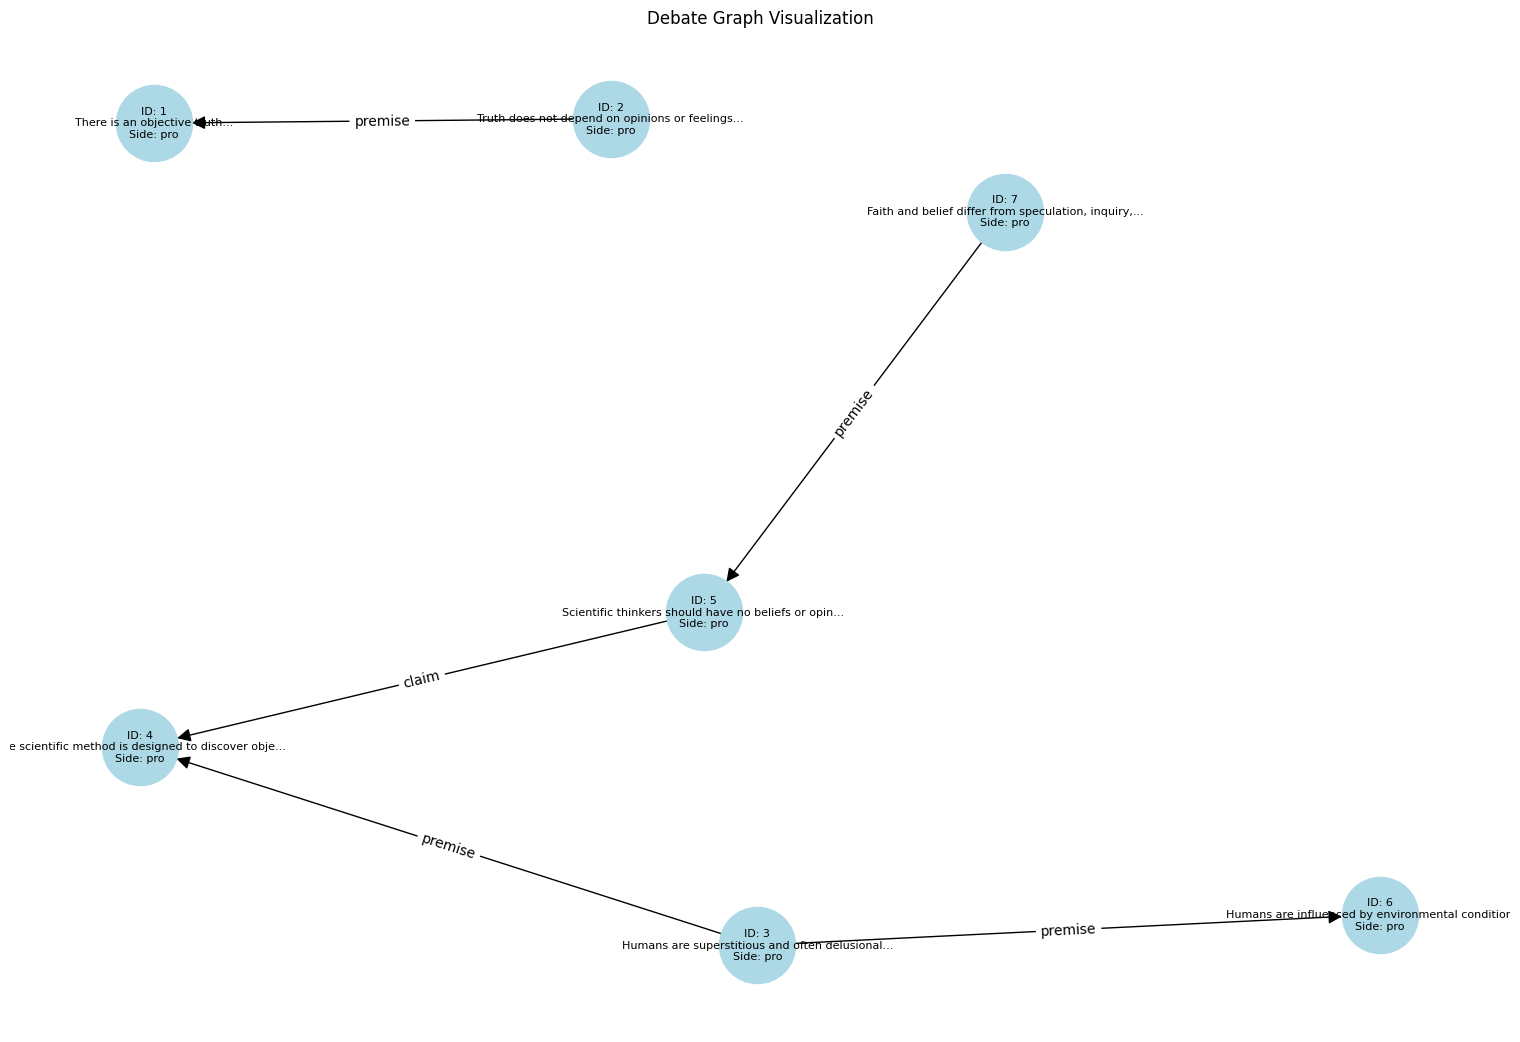

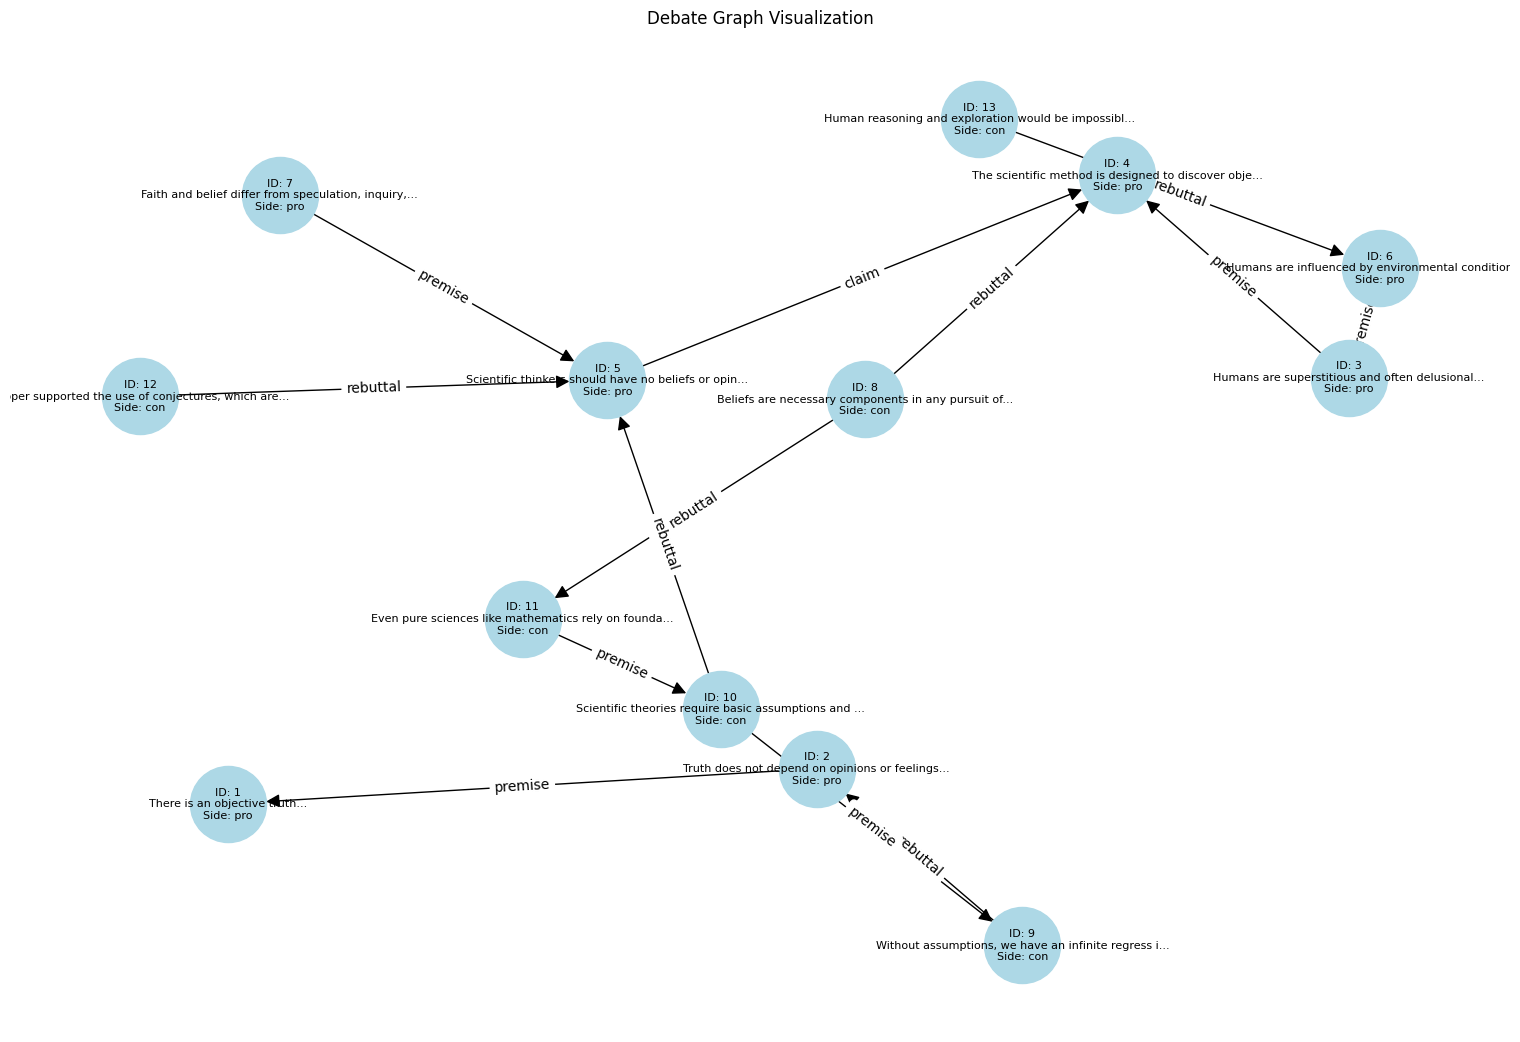

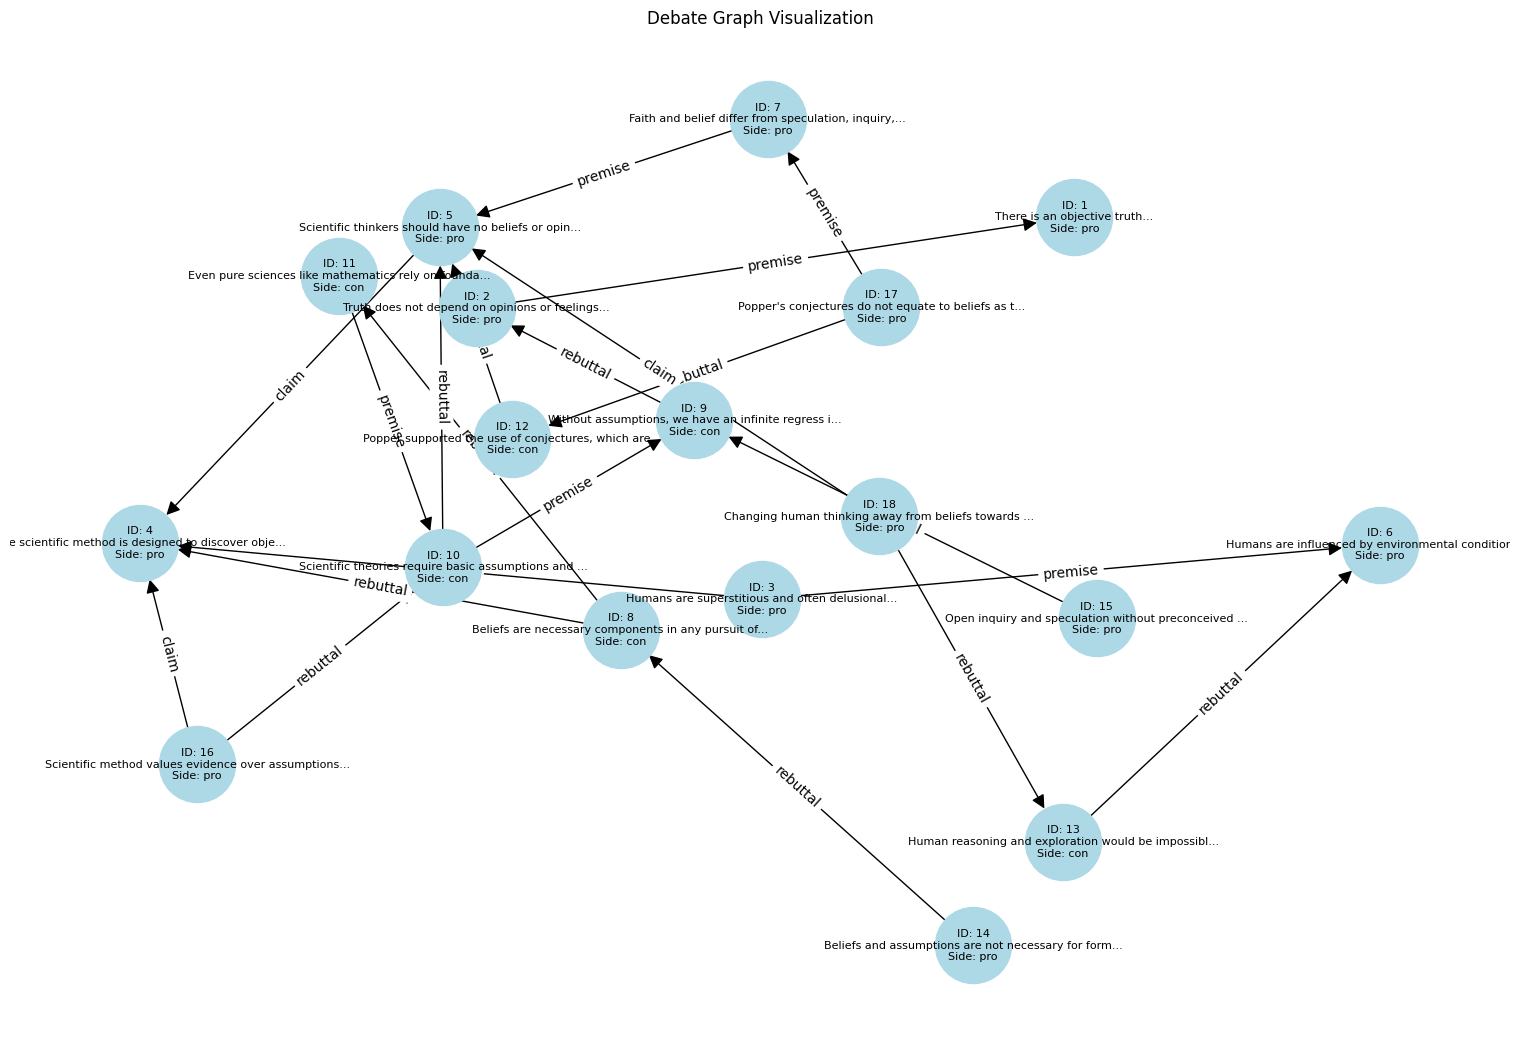

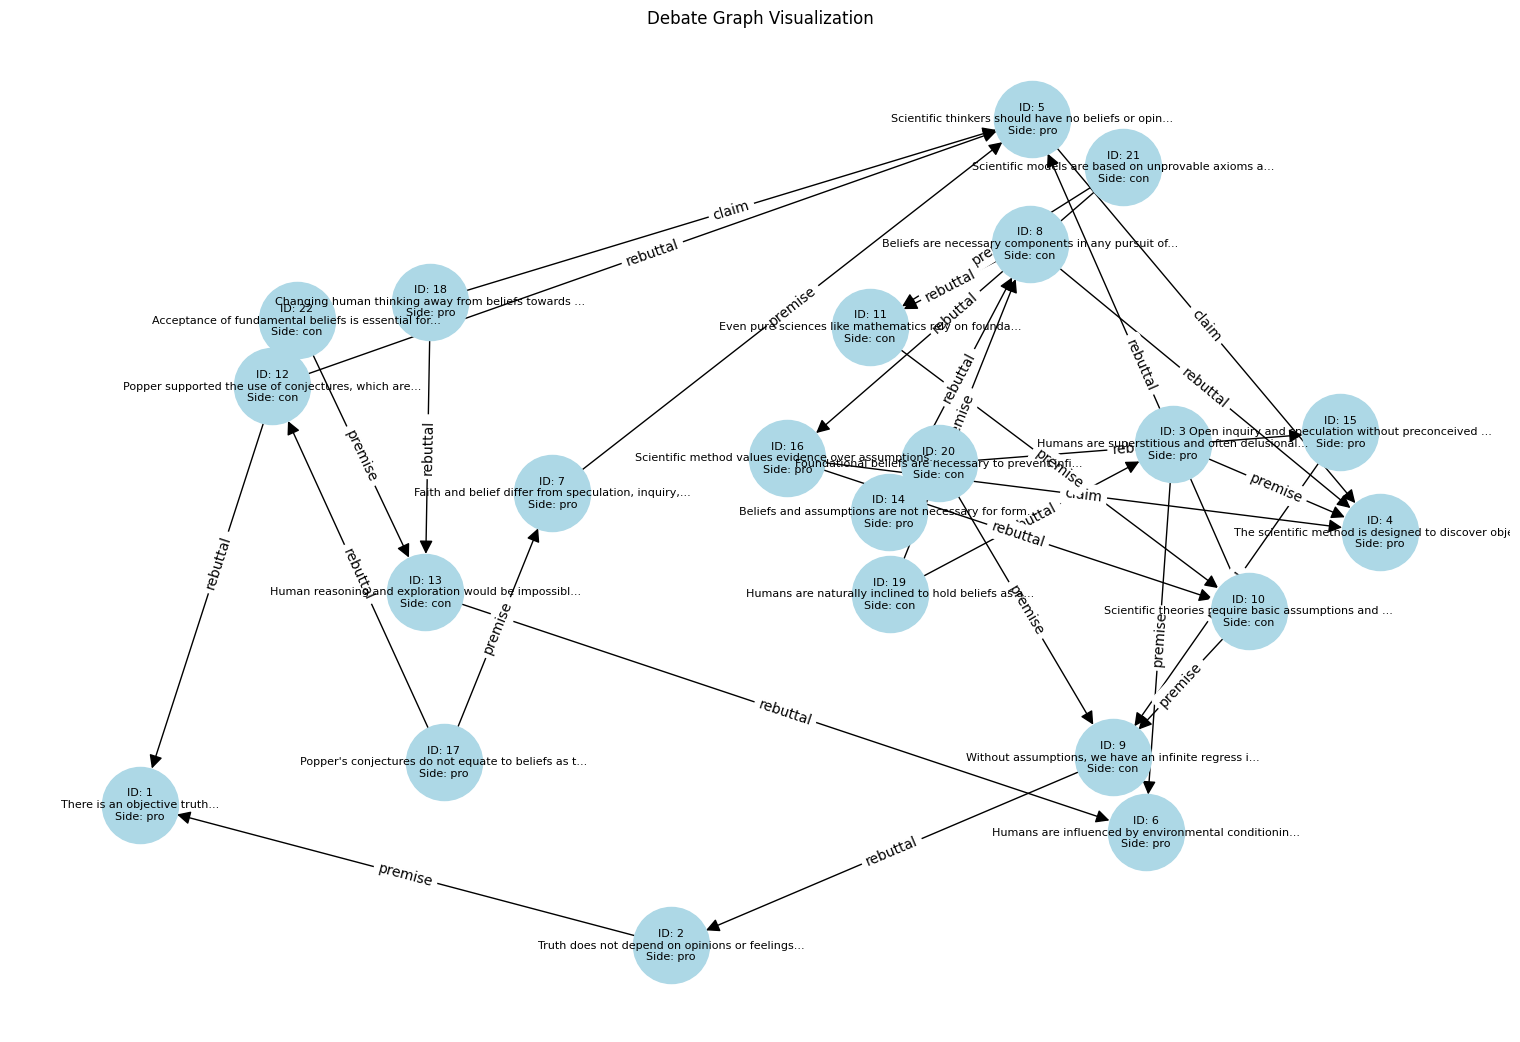

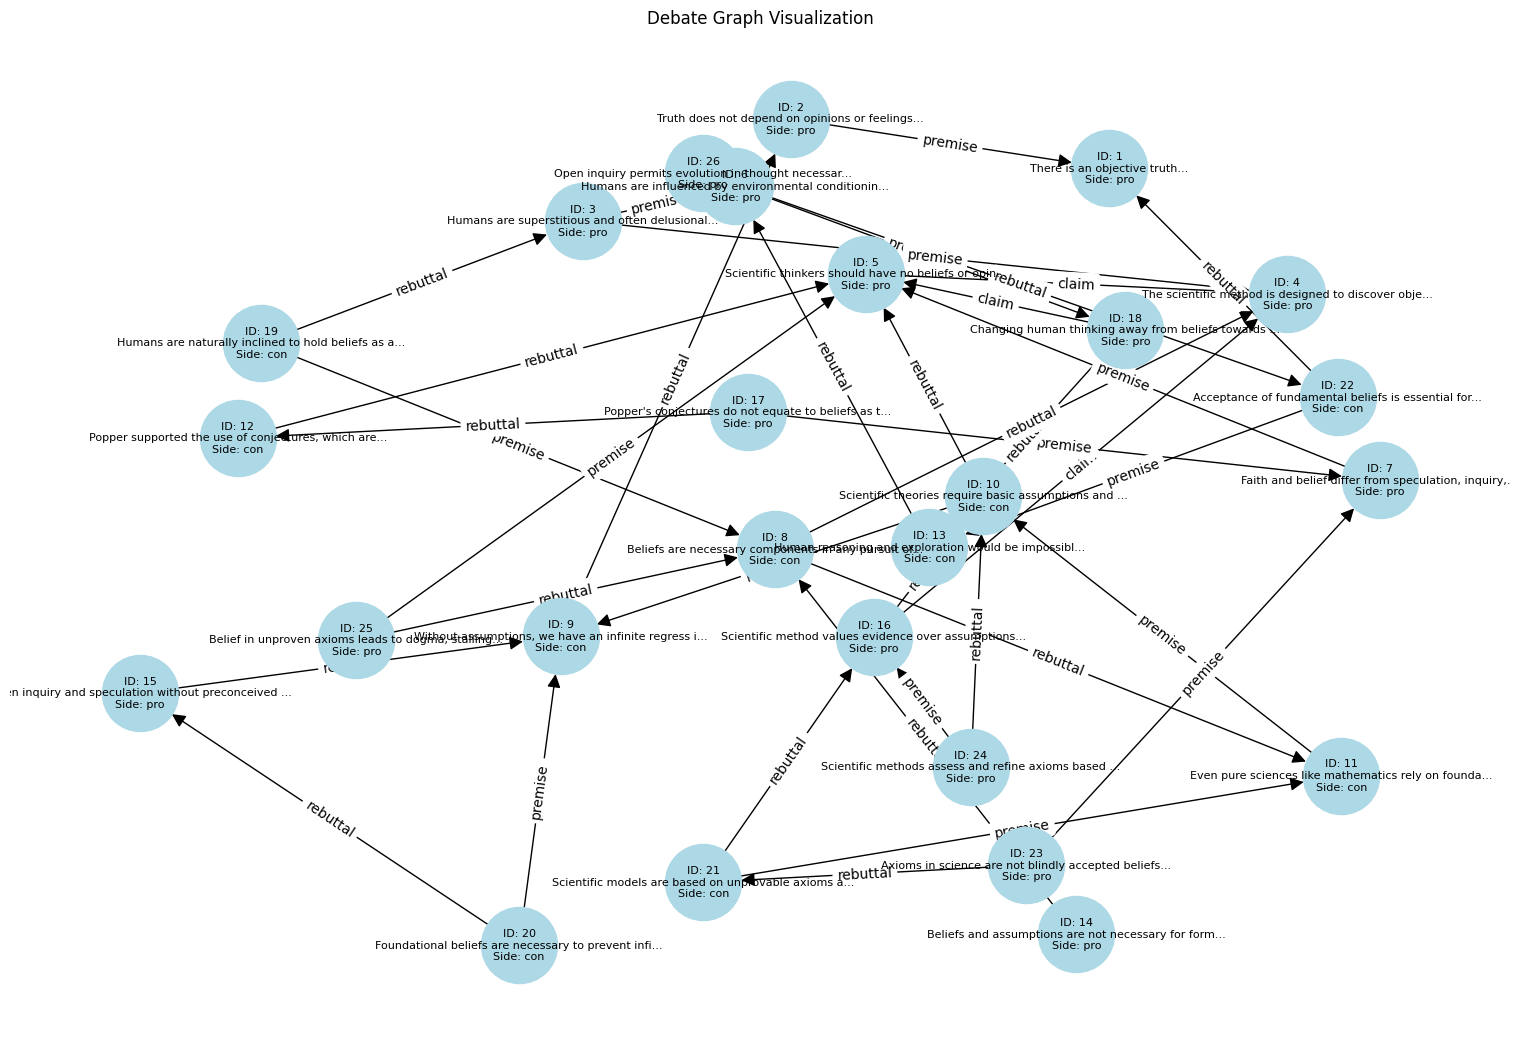

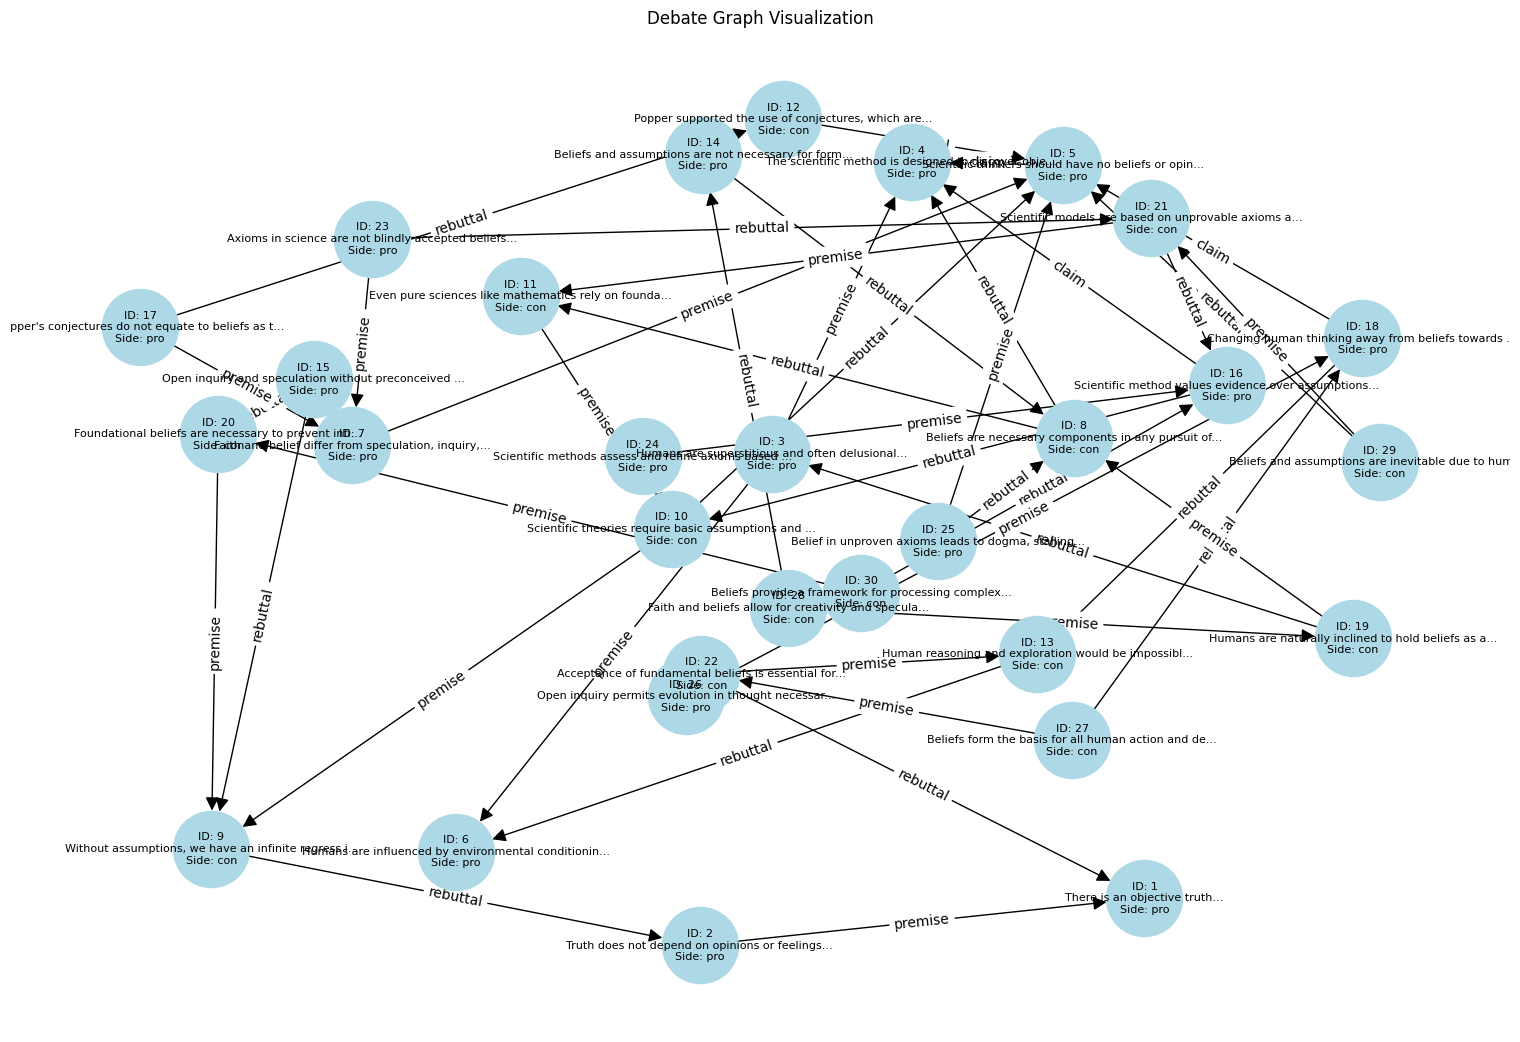

In [5]:
# Graphing evolution of debate graph
graph_all_scene_graphs(structs[0]['graph_history'])

In [6]:
pro_arguments = []
con_arguments = []

In [7]:
#factual accuracy 
for argument in structs[0]['graph_history'][-1].entities:
    if argument.side =='pro':
        pro_arguments.append(argument)
    elif argument.side =='con': 
        con_arguments.append(argument)


In [11]:
relationships = structs[0]['graph_history'][-1].relationships
entities = {entity.id: entity for entity in structs[0]['graph_history'][-1].entities}

rebuttals = []
for rel in relationships:
    if rel.relationship_type == 'rebuttal':
        source = entities[rel.source_id]
        target = entities[rel.target_id]
        rebuttals.append((source, target))

In [12]:
import os
from openai import OpenAI

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),  # This is the default and can be omitted
)


In [14]:
#combined code 
# Factual accuracy evaluation
def evaluate_factual_accuracy_gpt(statement):
    prompt = f"""
    Evaluate the factual accuracy of the following statement:

    "{statement}"

    Respond in the format and do not say anything else:
    - Factual: (True/False) respond with one word only
    - Confidence: (0.0 to 1.0 scale, where 1.0 is absolute confidence)
    - Feedback: Only if it's False, give a one-line explanation for why that is the case.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": "You are a fact-checking assistant."},
                      {"role": "user", "content": prompt}],
            max_tokens=100,
            temperature=0
        )
        content = response.choices[0].message.content
        
        # Parse the response
        factual = "True" in content.split("\n")[0]  # Check for factuality
        confidence_line = next(line for line in content.split("\n") if "Confidence:" in line)
        confidence = float(confidence_line.split("Confidence: ")[-1].strip())
        
        feedback_line = next((line for line in content.split("\n") if "Feedback:" in line), None)
        feedback = feedback_line.split("Feedback: ")[-1].strip() if feedback_line else None
        
        return int(factual), confidence, feedback
    except Exception as e:
        print(f"Error with OpenAI API: {e}")
        return 0, 0.0, None


# Evaluate all arguments
pro_results = [evaluate_factual_accuracy_gpt(arg) for arg in pro_arguments]
con_results = [evaluate_factual_accuracy_gpt(arg) for arg in con_arguments]

# Normalize factual accuracy scores and collect feedback
def calculate_normalized_score(results):
    total_score = sum(factuality * confidence for factuality, confidence, _ in results)
    max_score = len(results)  # Maximum possible score
    feedback = [feedback for _, _, feedback in results if feedback]  # Collect all feedback
    return total_score / max_score if max_score > 0 else 0, feedback

pro_score, pro_factual_feedback = calculate_normalized_score(pro_results)
con_score, con_factual_feedback = calculate_normalized_score(con_results)


# Persuasiveness evaluation
def evaluate_persuasiveness_gpt(pro_argument, con_argument):
    prompt = f"""
    Compare the following arguments and decide which is more persuasive:

    Pro Argument: "{pro_argument}"
    Con Argument: "{con_argument}"

    Respond with "Pro" or "Con" based on which is more persuasive.
    If you find either argument lacking, explain briefly why it is less persuasive.

    Respond in the format:
    - Persuasiveness: (Pro/Con)
    - Feedback: (Brief explanation if any argument is less persuasive)
    """
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a debate evaluator who determines persuasiveness."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=150,
            temperature=0
        )
        content = response.choices[0].message.content.strip()

        # Split response into lines, parse persuasiveness and feedback
        lines = content.split("\n")
        
        # Get Persuasiveness: Pro or Con from the first line
        persuasiveness = lines[0].replace('- Persuasiveness:', '').strip().lower()
        
        # Get Feedback: Extract the feedback from the second line
        feedback_line = next((line for line in lines if "Feedback:" in line), None)
        feedback = feedback_line.split("Feedback:")[-1].strip() if feedback_line else None

        return persuasiveness, feedback
    except Exception as e:
        print(f"Error with OpenAI API: {e}")
        return "Error", None


# Initialize scores and feedback collection for persuasiveness
pro_score_persuasion = 0
con_score_persuasion = 0
feedback_pro = []
feedback_con = []

# Evaluate rebuttals for persuasiveness
for source, target in rebuttals:
    if source.side == 'pro' and target.side == 'con':
        result, feedback = evaluate_persuasiveness_gpt(source.content, target.content)
    elif source.side == 'con' and target.side == 'pro':
        result, feedback = evaluate_persuasiveness_gpt(target.content, source.content)
    else:
        continue  

    # Update scores based on persuasiveness evaluation
    if result == "pro":
        pro_score_persuasion += 1
        if feedback:
            feedback_pro.append(feedback)
    elif result == "con":
        con_score_persuasion += 1
        if feedback:
            feedback_con.append(feedback)


# Normalize persuasiveness scores
total_rebuttals = pro_score_persuasion + con_score_persuasion
pro_score_persuasion_normalized = pro_score_persuasion / total_rebuttals if total_rebuttals > 0 else 0
con_score_persuasion_normalized = con_score_persuasion / total_rebuttals if total_rebuttals > 0 else 0

def find_entity_by_id(entities, node_id):
    return entities.get(node_id)  

# Argument structure evaluation: Count relationships
def count_nodes_with_relationship(relationships, relationship_type, entities):
    nodes_with_relationship = set()
    for rel in relationships:
        if rel.relationship_type == relationship_type:
            nodes_with_relationship.add(rel.source_id)
            nodes_with_relationship.add(rel.target_id)

    pro_count = 0
    con_count = 0
    for node in nodes_with_relationship:
        entity = find_entity_by_id(entities, node)
        if entity:  
            if entity.side == "pro":
                pro_count += 1
            elif entity.side == "con":
                con_count += 1
    return pro_count, con_count


# Count relationships for support, premise, rebuttal
support_pro_count, support_con_count = count_nodes_with_relationship(relationships, "support", entities)
premise_pro_count, premise_con_count = count_nodes_with_relationship(relationships, "premise", entities)
rebuttal_pro_count, rebuttal_con_count = count_nodes_with_relationship(relationships, "rebuttal", entities)

total_nodes = len(entities)

# Normalize argument structure scores
def normalize_score(pro_count, con_count, total):
    pro_score = pro_count / total if total > 0 else 0
    con_score = con_count / total if total > 0 else 0
    return pro_score, con_score

support_premise_pro_score, support_premise_con_score = normalize_score(
    support_pro_count + premise_pro_count,
    support_con_count + premise_con_count,
    total_nodes
)

rebuttal_pro_score, rebuttal_con_score = normalize_score(
    rebuttal_pro_count,
    rebuttal_con_count,
    total_nodes
)

total_pro_score_structure = (support_premise_pro_score + rebuttal_pro_score) / 2
total_con_score_structure = (support_premise_con_score + rebuttal_con_score) / 2


# Calculate the overall winner
total_pro_score = pro_score + pro_score_persuasion_normalized + total_pro_score_structure
total_con_score = con_score + con_score_persuasion_normalized + total_con_score_structure

if total_pro_score > total_con_score:
    overall_winner = "Pro"
elif total_con_score > total_pro_score:
    overall_winner = "Con"
else:
    overall_winner = "Tie"


# Display results
print(f"Pro Factual Accuracy Score: {pro_score:.2f}")
print(f"Con Factual Accuracy Score: {con_score:.2f}")
print(f"Pro Persuasiveness Score: {pro_score_persuasion_normalized:.2f}")
print(f"Con Persuasiveness Score: {con_score_persuasion_normalized:.2f}")
print(f"Pro Argument Structure Score: {total_pro_score_structure:.2f}")
print(f"Con Argument Structure Score: {total_con_score_structure:.2f}")
print(f"Overall Pro Score: {total_pro_score:.2f}")
print(f"Overall Con Score: {total_con_score:.2f}")
print(f"The overall winner is: {overall_winner}")

# Print feedback summaries
def print_feedback(feedback_list, side):
    if not feedback_list:
        print(f"No issues were found with the {side} arguments.")
    else:
        print(f"\nFeedback for {side} arguments:")
        for i, feedback in enumerate(feedback_list, 1):
            print(f"{i}. {feedback}")

print_feedback(pro_factual_feedback + feedback_pro, "Pro")
print_feedback(con_factual_feedback + feedback_con, "Con")


Pro Factual Accuracy Score: 0.81
Con Factual Accuracy Score: 0.93
Pro Persuasiveness Score: 0.36
Con Persuasiveness Score: 0.64
Pro Argument Structure Score: 0.48
Con Argument Structure Score: 0.45
Overall Pro Score: 1.66
Overall Con Score: 2.01
The overall winner is: Con

Feedback for Pro arguments:
1. Beliefs and assumptions play a crucial role in forming hypotheses as they guide the direction of inquiry and influence the interpretation of data.
2. Open inquiry and speculation without preconceived beliefs do not guarantee objective truth as biases and subjective interpretations can still influence the process.
3. Scientific thinkers can have beliefs and opinions about reality, as long as they are based on evidence and subject to revision based on new evidence.
4. The Pro argument emphasizing the scientific method's focus on evidence and truth is more persuasive as it appeals to logic and reason. The Con argument, while acknowledging the role of beliefs in processing information, lack

In [5]:
# Running on DebateArt
winners = {}
structs = {}
batch_number = 0
#for i, dart_id in enumerate(dart_ids):
for i, dart_id in enumerate(dart_ids):
    try:
        debate = manager.load_debate(dart_id)
        winner, struct = process_debate(debate)
        winners[dart_id] = winner
        structs[dart_id] = struct
        print(f"Processed debate ID {dart_id}")
        print(f"i: {i}")
        print(f"Winner: {winner}")

        if (i + 1) % 10 == 0:
            batch_number += 1
            save_results(winners, structs, batch_number)
    except Exception as e:
        print(f"Error processing debate ID {dart_id}: {e}")
        continue

print(winners)

KeyboardInterrupt: 

In [ ]:
# Benchmarking
ground_truth = {}
for dart_id in winners.keys():
    ground_truth[dart_id] = df.loc[(df['dart_id'] == int(dart_id)) & (df['dimension'] == 'argument')]['label'].values[0]

winners_float = {}
for dart_id in winners.keys():
    if winners[dart_id] == "pro":
        winners_float[dart_id] = 0.0
    elif winners[dart_id] == "con":
        winners_float[dart_id] = 1.0
    else:
        winners_float[dart_id] = 0.5
winners_float

gt = list(ground_truth.values())
wf = list(winners_float.values())
calculate_rmse(gt, wf)